# Predict the data quality of Protein, RNA and DNA structures which were deposited to the Protein Data Bank

#                        By Huanwang Shawn Yang




# Summary: 

This project is to utilize Machine Learning algorithms to predict the quality of Protein, RNA and DNA structures deposited at the Protein Data Bank, based on the annotated data. Since the target (quality) value is numerical data (ranking from 0 to 100), regression algorithm was used for prediction. Various methodologies have been tested, such as feature engineering, feature selection, ML algorithms, and the associated best hyperparameters. Extremely high accuracy has been obtained as can be seen below.


# Understand the data below

Eighteen 18 features are selected from more than 100 variables storied in the relational database. There are about 110000 number of observations. 

The data items are the followings:

'prfee' : The percentile of free R value   
'pclash': The percentile of clashes  
'prama': The percentile of Ramachandran plot  
'prota' : The percentile of rotamers   
'prsrz':  The percentile of real space Z score   
'clash':  atom clashes   
'rama': Ramachandran plot   
'rota' : rotamers   
'rsrz' : real space Z score   
'twin' : twin or un-twined   
'comp':  data completness   
'reso' : resolution   
'B'   : The B factors   
'rfree': the free R value    
'esu': the estimated coordinate error    
'redund': the data redundency   
'sigi' : I/sigI   
'type' : The protein type  (Protein, RNA, DNA) 

# Result

GradientBoostingRegressor was automatically selected with the best hyperparameters. The test set gives very good results as shown below.

r2_score= 0.98128906665

mean_squared_error= 7.72836312849

root_mean_squared_error= 2.77999336842

Cross validation = 0.97891879445945895


In [1]:
# import some of libraries

import sys
sys.path.append('/Users/hyang/data-science/Pyth/ML-tune/') 
import ml_tune_para as tune  #use pre-developed module

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)


/Users/hyang/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hyang/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#==========================
def get_dataframe():
    '''
    '''
    df=pd.read_csv('pdb-clean.data', sep='\t') #
    df.drop(['structure_id', 'DCC_Rfree'], axis=1, inplace=True)
    names=['prfee', 'pclash', 'prama', 'prota','prsrz', 'clash', 'rama','rota','rsrz',
           'twin','comp', 'reso', 'B','rfree', 'esu', 'redund', 'sigi','type']

    df.columns=names  # change column name (just for easy reading)
    return df

df=get_dataframe() 
df=df[0:4000] #only for fast test, Will use all data
#print 'Before data cleaning\n', df.describe()

In [3]:
#==========================
def data_clean(df):
    '''cleaning data after visulization and error detection
    '''
    
#check missing values
#    print df.isnull().any() #check if any colum has NULL
    miss = df.isnull().sum()/len(df)
    miss = miss[miss > 0]
    miss.sort_values(inplace=True)
    print '\nThe missing data =', miss
    df.drop_duplicates(keep=False)
    
    outliers=dict(B=[0,600], comp=[0,101], sigi=[0, 150], redund=[0,150], clash=[0,150])
    print  outliers
    
#reset values for the outliers
    
    for key in outliers.keys(): 
        df.loc[df[key]< outliers[key][0], key]=outliers[key][0]
        df.loc[df[key]> outliers[key][1], key]=outliers[key][1]
    
        
#remove rows if found an outliers       
#    for key in outliers.keys(): df=df[(df[key]>outliers[key][0]) & (df[key]<=outliers[key][1])]
        
#replace value by percentile
#    for key in outliers.keys(): df=df[df[key] < np.percentile(df[key],99.0)]
        
    #redefine the target 
    df['target']=(df['prfee'] + df['pclash'] + df['prama'] + df['prota'] + df['prsrz'])/5.0
    df.drop(['prfee', 'pclash', 'prama', 'prota','prsrz'], axis=1, inplace=True)

#---check and clean data-----
    df.loc[:'type'].replace(['polypeptide(L)','polydeoxyribonucleotide', 
                            'polyribonucleotide'], ['protein','dna','rna'], inplace=True)

#either remove or rename as protein (here rename)
    df.loc[:'type'].replace(['other','cyclic-pseudo-peptide', 'polypeptide(D)'],
                           ['protein','protein','protein'], inplace=True)
    return df

df=data_clean(df)
print '\nAfter data cleaning/imputing =\n', df.describe()
print 'New dimension = ', df.shape
#print 'df.dtypes=\n', df.dtypes


The missing data = Series([], dtype: float64)
{'sigi': [0, 150], 'comp': [0, 101], 'redund': [0, 150], 'B': [0, 600], 'clash': [0, 150]}

After data cleaning/imputing =
             clash         rama         rota         rsrz         twin  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     13.821415     0.980205     4.810000     4.668240     0.319171   
std      11.333900     1.707850     4.610746     7.005353     0.023314   
min       0.000000     0.000000     0.000000     0.000000     0.083000   
25%       6.547500     0.000000     1.770000     1.370000     0.313000   
50%      10.580000     0.410000     3.510000     3.120000     0.323000   
75%      17.352500     1.160000     6.430000     5.820000     0.330000   
max     140.800000    19.050000    49.060000   100.000000     0.466000   

              comp         reso            B        rfree          esu  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     92.607

The quality of protein, RNA, and DNA=
         target
type           
dna       27.08
protein   44.18
rna       24.33
Check counts of protein, RNA, and DNA
protein    3853
dna          99
rna          48
Name: type, dtype: int64


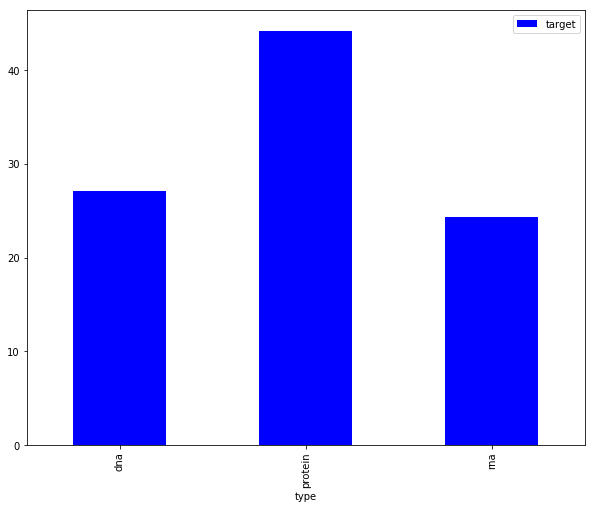

In [4]:
#check the quality for protein, rna, dna  
# looks like protein structure have high quality

cat_pivot = df.pivot_table(index='type', values='target', aggfunc=np.median)
print 'The quality of protein, RNA, and DNA=\n', cat_pivot
cat_pivot.plot(kind='bar',color='blue')
print 'Check counts of protein, RNA, and DNA\n', df['type'].value_counts()


/Users/hyang/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



The skewness of target is 0.192881582726

Do Q-Q plot to see if the target is normal distributed

Plot heatmap to show correlations among the features.

Show how the target is correlated with other features
(target    1.000000
twin      0.157660
comp      0.083258
sigi      0.067953
redund   -0.014442
esu      -0.042457
rsrz     -0.310797
B        -0.340607
rota     -0.565590
rama     -0.575543
reso     -0.593643
clash    -0.665376
rfree    -0.681603
Name: target, dtype: float64, '\n')

Do boxplot to see any outliers

Check each data distribution

 plot the most correlated target with features


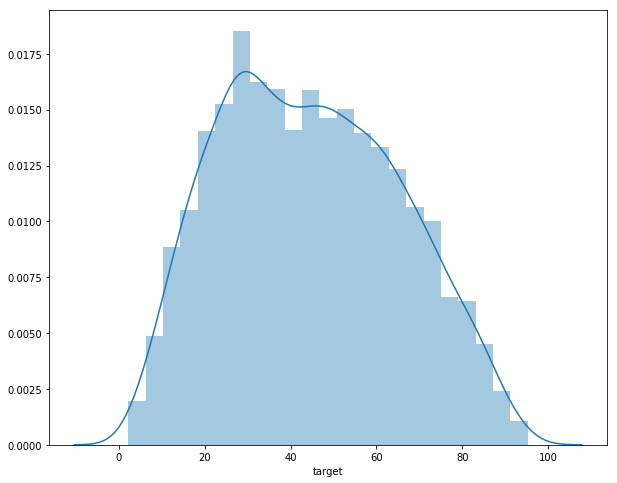

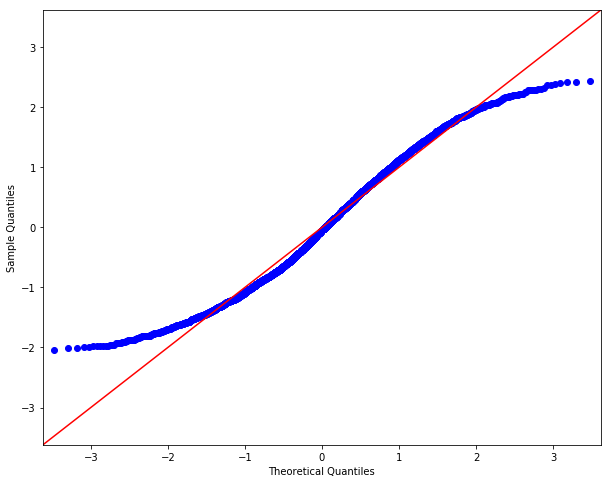

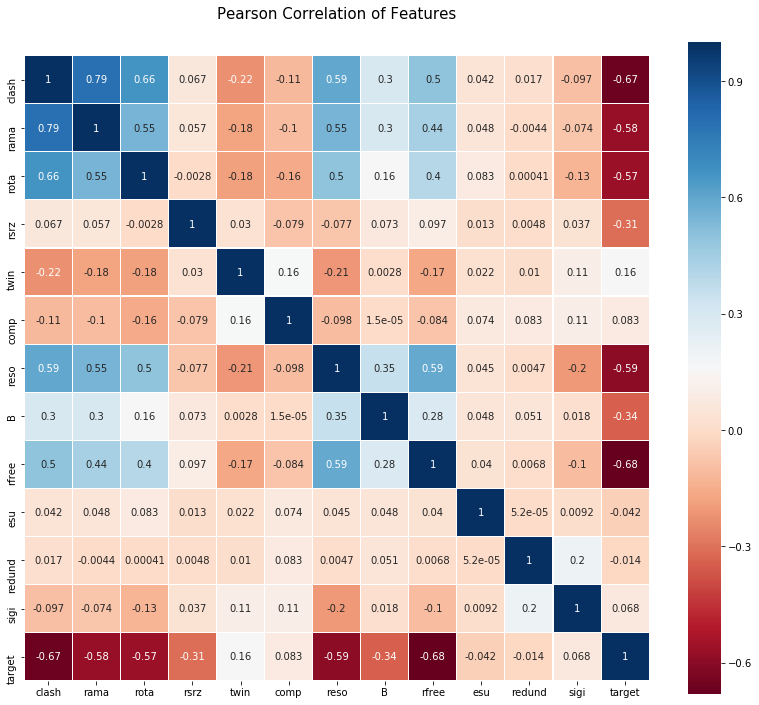

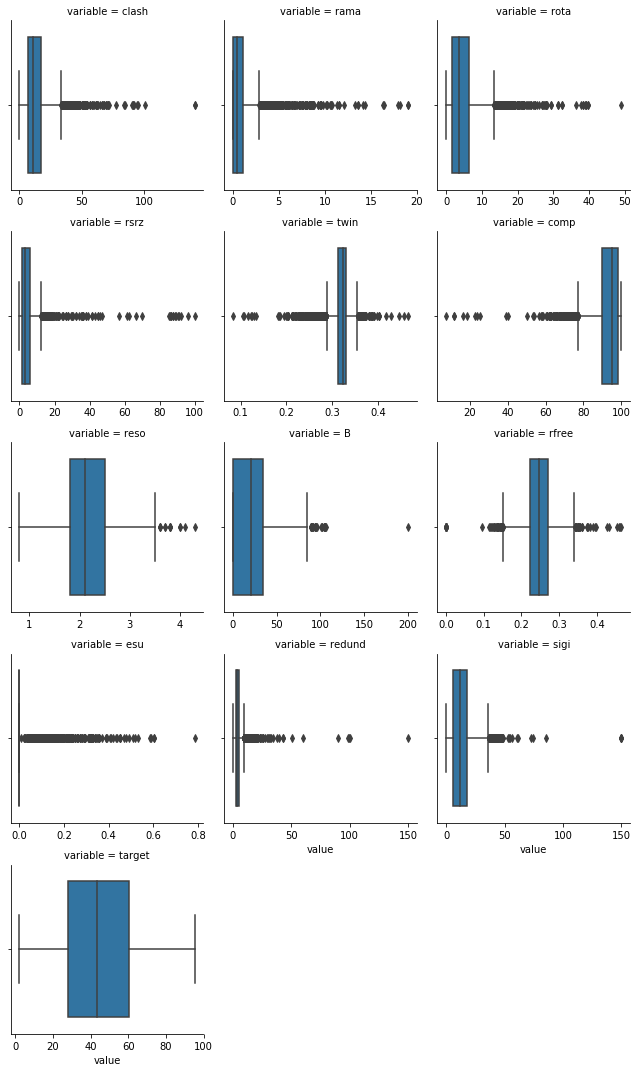

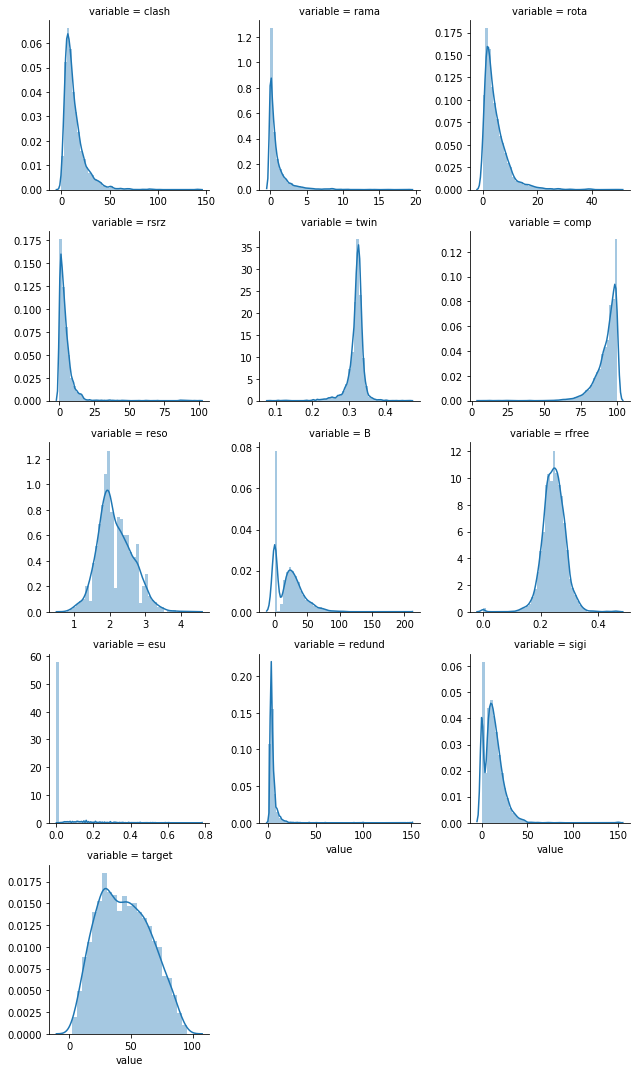

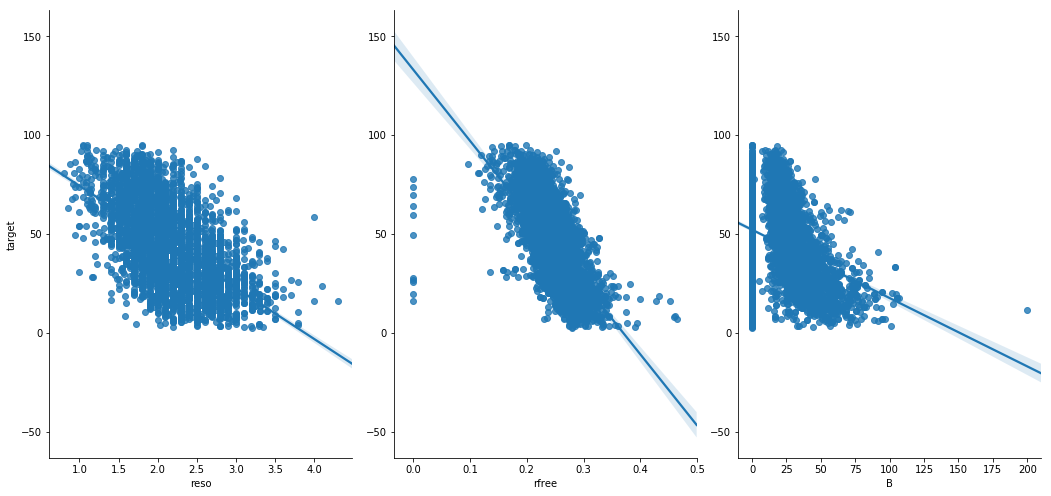

In [5]:
#==========================
def boxplot(x,y,**kwargs):                
    sns.boxplot(x=x,y=y)
    x = plt.xticks(rotation=90)
    
def visulization(df):
    '''see if data has problems
    '''
    import statsmodels.api as sm

# separate variables into nemerical and categorical data data for checking
    num = df.select_dtypes(include=[np.number])
    cat = df.select_dtypes(exclude=[np.number])
    
    sns.distplot(df['target']) #plot
    print "\nThe skewness of target is {}".format(df['target'].skew())

    #sns.distplot(np.log(df['target']))  #more skewed!
    
    print '\nDo Q-Q plot to see if the target is normal distributed'
    sm.qqplot(df['target'], stats.t, fit=True, line='45') #show if normal dist
#    plt.show()

    print '\nPlot heatmap to show correlations among the features.'
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    pcorr=num.astype(float).corr()
    sns.heatmap(pcorr,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
#    sns.heatmap(corr, cmap='RdYlGn_r', linewidths=0.5, annot=True) #correlation maps
#    plt.show()
    print '\nShow how the target is correlated with other features'
    print (pcorr['target'].sort_values(ascending=False), '\n') 

    #print num['reso'].unique()
    #pivot = num.pivot_table(index='reso', values='target', aggfunc=np.median)
    #print pivot
    #pivot.plot(kind='bar', color='red')
    #plt.show()

    #sns.jointplot(x=num['reso'], y=num['target'])
    #plt.show()

    #create numeric plots
    num_col = [col for col in num.columns if num.dtypes[col] != 'object']
    nd = pd.melt(num, value_vars = num_col)
    print '\nDo boxplot to see any outliers'
    n1 = sns.FacetGrid (nd, col='variable', col_wrap=3, sharex=False, sharey = False)
    n1 = n1.map(sns.boxplot, 'value')
    n1
    print '\nCheck each data distribution'    
    n2 = sns.FacetGrid (nd, col='variable', col_wrap=3, sharex=False, sharey = False)
    n2 = n2.map(sns.distplot, 'value')
    n2
    
    '''   
    #create categorical plots
    cat = [col for col in df.columns if df.dtypes[col] == 'object']
    p = pd.melt(num, id_vars='target', value_vars=cat)
    g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
    g = g.map(boxplot, 'value','target')
    g
    '''
    print '\n plot the most correlated target with features'
    sns.pairplot(df, x_vars=['reso','rfree','B'], y_vars='target', size=7, aspect=0.7, kind='reg')

visulization(df) #look at the graphs
 

In [6]:
#==========================
def add_dummy(df):
    '''feature Engineering: change categorical to numerical use get_dummies
    '''    
    cat_var=['type']  #only one 
    for var in cat_var:
        cat_list = pd.get_dummies(df[var], prefix=var, drop_first=True)
        df=df.join(cat_list) 
        
    return df

df=add_dummy(df) #add dummy variables--    
print '\ndimension after adding dummy variables =', df.shape
df.drop('type', axis=1, inplace=True) #drop it, no longer useful


dimension after adding dummy variables = (4000, 16)


In [7]:
#==========================
def feature_selection(X, Y, ftype):
    '''select the best feature to reduce noise, overfit
    '''
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    from sklearn.feature_selection import RFE
    from sklearn.ensemble import RandomForestRegressor

    if ftype=='CHI2':
        test = SelectKBest(score_func=chi2, k=10)
        fit = test.fit(X, Y)
        features = fit.transform(X)
    
        print('testing feature score=', fit.scores_)
        print('features=',features[:5,])
        return features 
    
    elif ftype=='RFE': #  Recursive Feature Elimination (RFE) 
        model = RandomForestRegressor()
        clf = RFE(model, 10)
        clf = clf.fit(X,Y)
        print('clf.support_=', clf.support_)
        X_col=X.columns
        features=[]  #get the best features
        for i, x in enumerate(clf.support_):
            if x:
                features.append(X_col[i])
        print(clf.ranking_), features

        return features

In [8]:
#Prepare data and select the best features

Y=df['target']  #separate target and features 
#    Y=Y.astype('int') #
X=df.drop('target',axis=1) 
    
features=feature_selection(X,Y,'RFE')  #or CHi2
#features=['twin', 'comp', 'reso', 'rfree', 'redund', 'sigi']
#features=['comp', 'reso', 'rfree', 'B']
X=X[features]
print '\Summary for the selected featuers=\n', X.describe()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7) 

print 'Training and testing demension=', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


('clf.support_=', array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False], dtype=bool))
[1 1 1 1 1 1 1 1 1 3 1 2 4 5] ['clash', 'rama', 'rota', 'rsrz', 'twin', 'comp', 'reso', 'B', 'rfree', 'redund']
\Summary for the selected featuers=
             clash         rama         rota         rsrz         twin  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     13.821415     0.980205     4.810000     4.668240     0.319171   
std      11.333900     1.707850     4.610746     7.005353     0.023314   
min       0.000000     0.000000     0.000000     0.000000     0.083000   
25%       6.547500     0.000000     1.770000     1.370000     0.313000   
50%      10.580000     0.410000     3.510000     3.120000     0.323000   
75%      17.352500     1.160000     6.430000     5.820000     0.330000   
max     140.800000    19.050000    49.060000   100.000000     0.466000   

              comp         reso          

In [9]:
# use the developed module to get the best algorithm and parameters

tune.auto_tune_regressor(X_train, Y_train) #auto tune parameter

'''
the winner is ExtraTreesRegressor
score= 0.960307
hyper_para= {'max_features': None, 'n_estimators': 20, 'criterion': 'mse', 'max_depth': None}

'''



Tuning hyperparameters for sklearn.ensemble.RandomForestRegressor ...
('\nbest_score=', 0.9740437056067289)
('best_params=', {'max_features': 'auto', 'n_estimators': 120, 'criterion': 'mse', 'max_depth': None})
('best_estimator=', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))

Tuning hyperparameters for sklearn.ensemble.weight_boosting.AdaBoostRegressor ...
('\nbest_score=', 0.9334876972496159)
('best_params=', {'n_estimators': 80, 'loss': 'square', 'learning_rate': 1.0})
('best_estimator=', AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='square',
         n_estimators=80, random_state=None))

Tuning hyperparameters for sklearn.ensemble

/Users/hyang/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hyang/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hyang/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hyang/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

('\nbest_score=', 0.5902726775018567)
('best_params=', {'l1_ratio': 1.0})
('best_estimator=', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=1.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))

Tuning hyperparameters for sklearn.linear_model.BayesianRidge ...
('\nbest_score=', 0.688760190581867)
('best_params=', {})
('best_estimator=', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False))

The file (tuned_para.log) contains the sorted score, hyper_parameters, models



"\nthe winner is ExtraTreesRegressor\nscore= 0.960307\nhyper_para= {'max_features': None, 'n_estimators': 20, 'criterion': 'mse', 'max_depth': None}\n\n"

In [12]:
#==========================
def pdb_predict(df):
    '''This project is to predict the data quality deposited to the Protein Data Bank
    '''
    #tune.auto_tune_regressor(X_train, Y_train) #auto tune parameters
    '''after running the module, the best ML algorithm and hyperparameters are determined
    The winner is RandomForestRegressor.
    
    '''
    from  sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
    from  sklearn.ensemble import RandomForestRegressor
    from  sklearn.ensemble import ExtraTreesRegressor
    
    model= GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=120,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
    
    model.fit(X_train, Y_train) #fit the training data
    
    pred = model.predict(X_test)
    tune.write_result_regr(pred, Y_test, 'GradientBoostingRegressor')
    return model
model=pdb_predict(df)


Using GradientBoostingRegressor for prediction

r2_score= 0.98128906665

mean_squared_error= 7.72836312849

root_mean_squared_error= 2.77999336842


In [14]:
# calculate cross-validated 
from sklearn.cross_validation import cross_val_score

print 'Do 10 folder cross validation:'
cross_val_score(model, X_train, Y_train, cv=10).mean()


Do 10 folder cross validation:


0.97891879445945895